In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jvp, kvp, jn_zeros, jnp_zeros
from scipy.optimize import fsolve

# Solving Characteristic equation of Hybrid modes

하이브리드 모드는 관례상 EH와 HE 모드로 불리는 모드를 말한다.  
특성방정식에서 q 값이 0 이 아닌 경우를 풀어 얻을 수 있다. 

## Hybrid mode equation

$$
\left[
	\frac{J_q'(u)}{u\,J_q(u)} + \frac{K_q'(w)}{w\,K_q}
\right]
\left[
	\left(
		\frac{n_1}{n_2}
	\right)^2 
	\frac{J_q'(u)}{u\,J_q(u)} + \frac{K_q'(w)}{w\,K_q}
\right]
=
q^2
\left(
	\frac{1}{u^2}+\frac{1}{w^2}
\right) 
\left[
	\left(
		\frac{n_1}{n_2}
	\right)^2 \frac{1}{u^2}+\frac{1}{w^2}
\right]
$$


In [42]:
def gen_eigen_eq(n1, n2, q, **kwargs):

  def jf(u):
    return jvp(q, u)/(u*jv(q,u))

  def kf(u):
    w = np.sqrt(v*v - u*u)
    return kvp(q, w)/(w*kv(q,w))

  def qf(u):
    w = np.sqrt(v*v - u*u)
    n_sq= (n1/n2)**2
    return q*q*(1/(u*u)+1/(w*w))*(n_sq/(u*u)+1/(w*w))
  
  def hybrid(u):
    n_sq= (n1/n2)**2
    return (jf(u)+kf(u))*(n_sq*jf(u)+kf(u))-qf(u)
  
  if kwargs.get("mode")=="hybrid":
    return hybrid

Roots=[4.69233993 6.92095828 7.6471764  9.97886476]


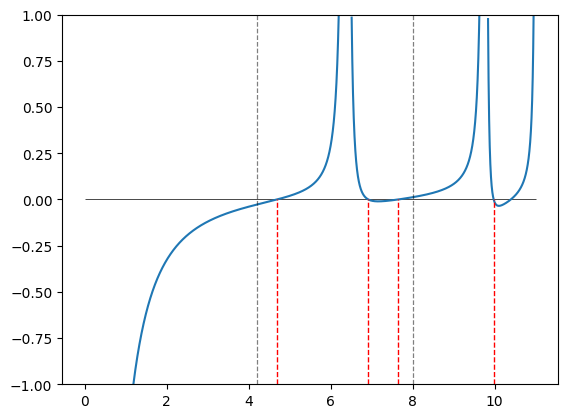

In [91]:
v = 11
n1 = 1.444
n2 = 1.458
q = 3
eigen_hybrid = gen_eigen_eq(n1,n2,q, mode='hybrid')
roots = fsolve(eigen_hybrid, [5, 6.5, 7.5, 9.8])
print(f"Roots={roots}")


fig,ax = plt.subplots()
plot_limit = 1
ax.set_ylim(-plot_limit, plot_limit)
ax.hlines(y=0, xmin=0, xmax=v, colors='k', linewidth=0.5) # plot x axis.
u = np.linspace(0.0001, v-0.0001, int(v*1000))
eigen_hybrid = np.where(abs(eigen_hybrid(u)) >= plot_limit, None, eigen_hybrid(u))
ax.plot(u, eigen_hybrid)
ax.vlines(x=roots, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='r', linewidth=1.0, label="Roots")
ax.vlines(x=jnp_zeros(q,2), ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k', alpha=0.5, linewidth=0.9)